## Transfer Learning for CV tutorial

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

## Load Data

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

DATA_DIR = 'data/hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x])
                 for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x : len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

USE_CUDA = True
if USE_CUDA:
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
        USE_CUDA = False
else:
    device = 'cpu'

## Visualize a few images

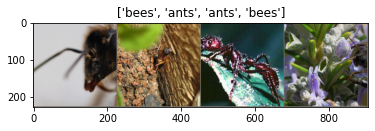

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            if phase =='val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f"Training Complete in {time_elapsed // 60:.0f}m {time_elapsed % 60}s")
    print(f"Best val Acc: {best_acc:4f}")
    
    model.load_state_dict(best_model_wts)
    return model

## Visualizing Model

In [25]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
            model.train(mode=was_training)

## Finetuning the convnet

In [22]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [23]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5507 Acc: 0.7295
val Loss: 0.1877 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.5035 Acc: 0.7623
val Loss: 0.4799 Acc: 0.7908

Epoch 2/24
----------
train Loss: 0.4503 Acc: 0.7746
val Loss: 0.2445 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.4701 Acc: 0.8074
val Loss: 0.6648 Acc: 0.7843

Epoch 4/24
----------
train Loss: 0.4826 Acc: 0.8279
val Loss: 0.2506 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.4555 Acc: 0.7951
val Loss: 0.4355 Acc: 0.8497

Epoch 6/24
----------
train Loss: 0.3501 Acc: 0.8730
val Loss: 0.2356 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3050 Acc: 0.8730
val Loss: 0.2157 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.2648 Acc: 0.8852
val Loss: 0.2264 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.2556 Acc: 0.8893
val Loss: 0.2084 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2825 Acc: 0.8852
val Loss: 0.2152 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3213 Acc: 0.8770
val Loss: 0.2113 Acc: 0.9216

Ep

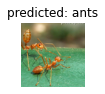

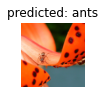

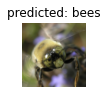

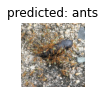

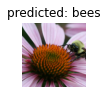

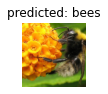

In [26]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

In [33]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate

In [34]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5189 Acc: 0.7295
val Loss: 0.2016 Acc: 0.9608

Epoch 1/24
----------
train Loss: 0.4666 Acc: 0.7910
val Loss: 0.2070 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.4067 Acc: 0.8361
val Loss: 0.1759 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.5324 Acc: 0.7664
val Loss: 0.1551 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4429 Acc: 0.8197
val Loss: 0.1695 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4168 Acc: 0.8238
val Loss: 0.2257 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.6152 Acc: 0.7787
val Loss: 0.1719 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3536 Acc: 0.8361
val Loss: 0.1684 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.2601 Acc: 0.8730
val Loss: 0.1597 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.3581 Acc: 0.8484
val Loss: 0.2369 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3474 Acc: 0.8566
val Loss: 0.1820 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.4052 Acc: 0.8443
val Loss: 0.1605 Acc: 0.9477

Ep

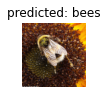

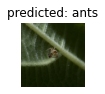

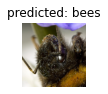

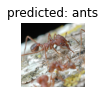

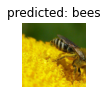

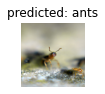

In [35]:
visualize_model(model_conv)

plt.ioff()
plt.show()